In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.data_util import load_augmented_example
from src.evaluation import DAP_SAP_MAP_kde, hist_AP, plot_SAP_MAP

import tensorflow as tf

from sklearn.model_selection import train_test_split
import glob
import json
import os

import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

2024-12-04 14:31:13.938342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 14:31:14.574861: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load training and validation data

![](images/hist_pig_samples_aug_v2.png)

The model is tuned using the augmented prepared data (hatched orange/blue) and the prepared original data (blue) and is validated using the validation data (green).

In [2]:
pigs = ["P_{0:02d}_PulHyp".format(i) for i in range(1, 11)]
print(pigs)

load_path = "/data/PulHypStudie_Check_npz_v2_SNR20/"

['P_01_PulHyp', 'P_02_PulHyp', 'P_03_PulHyp', 'P_04_PulHyp', 'P_05_PulHyp', 'P_06_PulHyp', 'P_07_PulHyp', 'P_08_PulHyp', 'P_09_PulHyp', 'P_10_PulHyp']


In [3]:
X_train, y_train, clrs_pig_train = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="upwards"
)

Selected 14500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_01_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_01_PulHyp/sample_014999.npz from pig P_01_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_02_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_02_PulHyp/sample_014999.npz from pig P_02_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_03_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_03_PulHyp/sample_014999.npz from pig P_03_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_04_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_04_PulHyp/sample_014999.npz from pig P_04_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_05_PulHyp/sample_000500.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_05_PulHyp/sample_014999.npz from pig P_05_PulHyp.
Selected 14500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_06_PulHyp/sample_000500.npz to /dat

In [4]:
X_valid, y_valid, clrs_pig_valid = load_augmented_example(
    load_path, pigs, sample_skip=500, load_samples="downwards"
)

Selected 500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_01_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_01_PulHyp/sample_000499.npz from pig P_01_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_02_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_02_PulHyp/sample_000499.npz from pig P_02_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_03_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_03_PulHyp/sample_000499.npz from pig P_03_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_04_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_04_PulHyp/sample_000499.npz from pig P_04_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_05_PulHyp/sample_000000.npz to /data/PulHypStudie_Check_npz_v2_SNR20/P_05_PulHyp/sample_000499.npz from pig P_05_PulHyp.
Selected 500 from /data/PulHypStudie_Check_npz_v2_SNR20/P_06_PulHyp/sample_000000.npz to /data/PulHypStud

In [5]:
print(
    X_train.shape,
    X_valid.shape,
    y_train.shape,
    y_valid.shape,
    clrs_pig_train.shape,
    clrs_pig_valid.shape,
)

(145000, 64, 1024, 1) (5000, 64, 1024, 1) (145000, 3) (5000, 3) (145000, 3) (5000, 3)


**PCA**

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(
    X_valid.reshape(X_valid.shape[0], X_valid.shape[1] * X_valid.shape[2])
)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

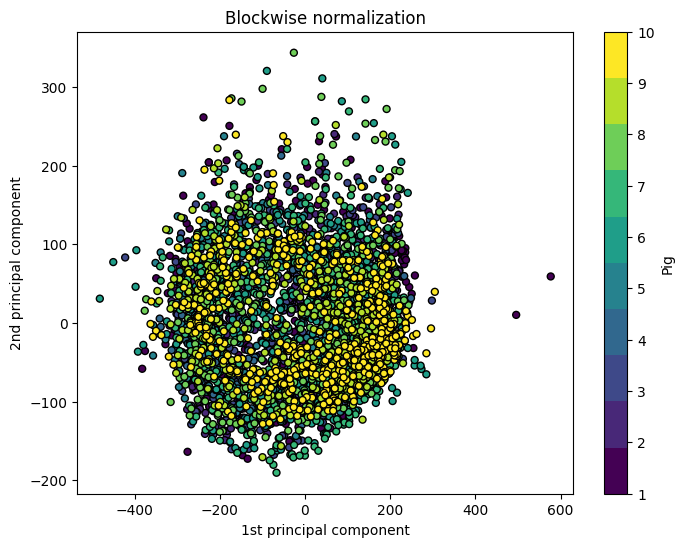

In [7]:
pigs_int = [int(c[0][4:6]) for c in clrs_pig_valid]

cmap = plt.get_cmap("viridis", np.max(pigs_int) - np.min(pigs_int) + 1)

plt.figure(figsize=(8, 6))
plt.title("Blockwise normalization")
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1], c=pigs_int, cmap=cmap, edgecolor="k", s=25
)

c_bar = plt.colorbar(scatter, ticks=np.arange(np.min(pigs_int), np.max(pigs_int) + 1))
c_bar.set_label("Pig")
c_bar.set_ticks(np.arange(np.min(pigs_int), np.max(pigs_int) + 1))

plt.xlabel("1st principal component")
plt.ylabel("2nd principal component")
plt.show()

## Hyperparameter Tuning 

- [Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)

In [8]:
import keras_tuner as kt
from tensorflow import keras

In [9]:
def build_model(hp):
    output_dim = 3
    
    model = keras.Sequential()
    # input layer
    model.add(keras.layers.Input(shape=(64, 1024, 1)))
    
    # tune the number of hidden layers and units in each.
    for i in range(1, hp.Int("num_layers", 4, 7)):
        print(f"Init layer {i=}")
        hp_units = hp.Int("units_" + str(i), min_value=2, max_value=16, step=4)
        hp_kernel = hp.Int("kernel_" + str(i), min_value=2, max_value=9, step=1)
        # stride dim (0,1)
        hp_strides_0 = hp.Int("units_0_" + str(i), min_value=1, max_value=4, step=1)
        hp_strides_1 = hp.Int("units_1_" + str(i), min_value=2, max_value=4, step=1)
        hp_activation = hp.Choice("activation_" + str(i), values=['relu','elu','tanh'])
        hp_dropout = hp.Float("dropout_" + str(i), 0, 1.0, step=0.1)
        
        # create layer
        model.add(
            keras.layers.Conv2D(hp_units, hp_kernel, strides=(hp_strides_0, hp_strides_1), padding="same")
        )
        model.add(keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation(hp_activation))
        model.add(keras.layers.Dropout(hp_dropout))

    model.add(keras.layers.Flatten())
    # output layer.
    model.add(keras.layers.Dense(output_dim, activation="linear"))
    
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4,1e-5])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.MeanAbsoluteError(),
                  # loss=keras.losses.MeanSquaredError(),
                  metrics=["accuracy"])
    print(model.summary())

    return model

In [10]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=2,
    directory='mapper_tuning',
    project_name='mapper_tuning_1'
)
# mapper_tuning_1 -> tuned on all pigs with MAE
# mapper_tuning_2 -> tuned on 9/10 pigs with MAE
# mapper_tuning_3 -> tuned on all pigs with MSE
# mapper_tuning_4 -> tuned on 9/10 pigs with MSE

2024-12-04 14:35:17.695432: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-12-04 14:35:18.189386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79087 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0
2024-12-04 14:35:19.661712: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79087 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:46:00.0, compute capability: 8.0
2024-12-04 14:35:19.667305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 79087 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

Init layer i=1
Init layer i=2
Init layer i=3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 512, 2)     │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 512, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 512, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 256, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 256, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 256, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 128, 2)     │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 128, 2)     │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 128, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 128, 2)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │        49,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,225 (192.29 KB)

 Trainable params: 49,213 (192.24 KB)

 Non-trainable params: 12 (48.00 B)

None


**Tune model on full data**

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
tuner.search(
    X_train,
    y_train,
    epochs=50,
    batch_size=8,
    validation_data=(X_valid, y_valid), 
    callbacks=[stop_early]
)

Trial 51 Complete [00h 03m 09s]
val_accuracy: 0.7730000019073486

Best val_accuracy So Far: 0.8399999737739563
Total elapsed time: 02h 26m 51s

Search: Running Trial #52

Value             |Best Value So Far |Hyperparameter
7                 |4                 |num_layers
10                |2                 |units_1
6                 |8                 |kernel_1
4                 |4                 |units_0_1
4                 |3                 |units_1_1
tanh              |elu               |activation_1
0.1               |0.1               |dropout_1
6                 |2                 |units_2
4                 |9                 |kernel_2
3                 |1                 |units_0_2
2                 |2                 |units_1_2
tanh              |tanh              |activation_2
0.2               |0.6               |dropout_2
14                |6                 |units_3
6                 |7                 |kernel_3
2                 |1                 |units_0_3
2         

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 256, 10)    │           370 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 256, 10)    │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16, 256, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 256, 10)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 128, 6)      │           966 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 128, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 6, 128, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 128, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 64, 14)      │         3,038 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 64, 14)      │            56 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 3, 64, 14)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 64, 14)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 32, 2)       │           114 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 32, 2)       │             8 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1, 32, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 32, 2)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 11, 6)       │           594 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1, 11, 6)       │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1, 11, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 11, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 3, 10)       │           970 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 3, 10)       │            40 │
│ (BatchNormalization)            │                        │             

 Total params: 6,337 (24.75 KB)

 Trainable params: 6,241 (24.38 KB)

 Non-trainable params: 96 (384.00 B)

None


/home/jt292/miniconda3/envs/TF/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


**Train the model with the parameters from the hpt on the first nine pigs**

In [ ]:
from glob import glob
m_idx = len(glob("src/weights/*.h5")) + 1

In [ ]:
# load all pigs excluding pig 10
pigs_train = ["P_{0:02d}_PulHyp".format(i) for i in range(1, 10)]
X_expt10, y_expt10, clrs_pig_expt10 = load_augmented_example(
    load_path, pigs_train, sample_skip=0, load_samples="upwards"
)

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
model = tuner.hypermodel.build(best_hps)

In [ ]:
history = model.fit(
    X_expt10,
    y_expt10,
    epochs=50,
    batch_size=8,
    validation_split=0.1,
)

In [ ]:
model.save_weights(f"src/weights/mapper_model_{m_idx}.weights.h5")

**Test model performance with trained model**

In [ ]:
# load pig 10 as the test pig
pigs_test = ["P_10_PulHyp"]
X_10, y_10, clrs_pig_10 = load_augmented_example(
    load_path, pigs_test, sample_skip=6552, load_samples="downwards"
)

In [ ]:
# predict EIT data of pig 10
y_pred = model.predict(X_10)

In [ ]:
# scale all AP values to the initial scale
dap_factor = 180
sap_factor = 180
map_factor = 160

Y_true[:, 0] = y_10[:, 0] * dap_factor  # dap normalization
Y_true[:, 1] = y_10[:, 1] * sap_factor  # sap normalization
Y_true[:, 2] = y_10[:, 2] * map_factor  # map normalization

Y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
Y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
Y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization

np.savez(f"src/results/result_mapper_{m_idx}.npz",
        Y_true = Y_true,
        Y_pred = Y_pred,
)

**Error estimation**

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
DAP_err = Y_true[:,0]-Y_pred[:,0]
SAP_err = Y_true[:,1]-Y_pred[:,1]
MAP_err = Y_true[:,2]-Y_pred[:,2]

In [ ]:
DF_err = pd.DataFrame({"DAP": DAP, "SAP":SAP, "MAP": MAP})
DF_err.to_csv(f"src/results/mapper_{m_idx}.csv", index=False)

In [ ]:
sns.histplot(DF_err)
plt.savefig(f"src/results/histplot_{m_idx}.png")

In [ ]:
sns.boxplot(DF_err)
plt.grid()
plt.savefig(f"src/results/boxplot_{m_idx}.png")

# Archive

In [ ]:
plt.plot(history.history["accuracy"], label="Training")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

**Predict test data**

- `y_pred` ...  Predicted data in true AP value range
- `y_true` ...  True AP data in true value range
- `y_test` ...  True AP data in scaled value range

In [ ]:
dap_factor = 180
sap_factor = 180
map_factor = 160
y_true = np.zeros(y_valid.shape)

y_true[:, 0] = y_valid[:, 0] * dap_factor  # dap normalization
y_true[:, 1] = y_valid[:, 1] * sap_factor  # sap normalization
y_true[:, 2] = y_valid[:, 2] * map_factor  # map normalization

In [ ]:
y_pred = model.predict(X_valid)  # X_valid
y_pred[:, 0] = y_pred[:, 0] * dap_factor  # dap normalization
y_pred[:, 1] = y_pred[:, 1] * sap_factor  # sap normalization
y_pred[:, 2] = y_pred[:, 2] * map_factor  # map normalization

In [ ]:
m_idx = len(glob.glob("models/model_aug/*.h5")) + 1
print("Model:", m_idx)
np.savez(
    f"models/model_aug/model_{m_idx}.npz",
    accuracy=history.history["accuracy"],
    loss=history.history["loss"],
    val_accuracy=history.history["val_accuracy"],
    val_loss=history.history["val_loss"],
)

Test data loss, accuracy, and least-squares solution $$y = mx + n$$ for SAP, MAP and DAP predictions.

In [ ]:
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)

accs_dct = {
    "model": m_idx,
    "test_loss": test_loss,
    "test_acc": test_acc,
}

lst_sqrs = ["DAP_m", "DAP_n", "SAP_m", "SAP_n", "MAP_m", "MAP_n"]
fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
ax[0].set_ylabel("Model (mmHg)")
for ap in range(y_pred.shape[1]):
    y = y_true[:, ap]
    x = y_pred[:, ap]
    A = np.vstack([y, np.ones(len(y))]).T
    m, n = np.linalg.lstsq(A, x, rcond=None)[0]

    accs_dct[lst_sqrs[ap * 2]] = m
    accs_dct[lst_sqrs[ap * 2 + 1]] = n

    x_f = np.linspace(0, 200)
    ax[ap].set_xlabel("Gold Standard (mmHg)")
    ax[ap].set_xlim(0, 200)
    ax[ap].set_ylim(0, 200)
    ax[ap].set_title(lst_sqrs[ap * 2][:3])
    ax[ap].plot(y, x, "o", label="Original data", markersize=1)
    ax[ap].plot(x_f, m * x_f + n, "r", label="Fitted line")
plt.legend()
plt.show()

with open(f"models/model_aug/acc_{m_idx}.json", "w") as json_file:
    json.dump(accs_dct, json_file)

In [ ]:
DAP_SAP_MAP_kde(y_pred, y_true)

In [ ]:
df_SAP = hist_AP(y_pred, y_true, AP="SAP")
df_MAP = hist_AP(y_pred, y_true, AP="MAP")

plot_SAP_MAP(df_SAP, df_MAP)

In [ ]:
df_SAP.to_csv(f"models/model_aug/df_SAP_{m_idx}.csv", index=False)
df_MAP.to_csv(f"models/model_aug/df_MAP_{m_idx}.csv", index=False)

In [ ]:
acc_measure = dict(Model=list(), Error_val=list(), Error=list())

data_append = []
Errors_names = ["DAP", "SAP", "MAP"]

for pred, true in zip(y_pred, y_true):
    err = pred - true
    for e in range(3):
        data_append.append(dict(Model=m_idx, Error_val=err[e], Error=Errors_names[e]))
for item in data_append:
    for key, value in item.items():
        acc_measure[key].append(value)

acc_measure_df = pd.DataFrame(acc_measure).dropna()
acc_measure_df.to_csv(f"models/model_aug/sgl_box_m_{m_idx}.csv", index=False)
acc_measure_df

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

sns.boxplot(x="Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=True)
plt.ylabel("Error (%)")
# plt.xlabel("Model Iteration")

In [ ]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_context(context="paper", font_scale=1.4)

combined_df = pd.concat(
    [
        pd.read_csv(f_csvs)
        for f_csvs in np.sort(glob.glob("models/model_aug/sgl_box*.csv"))
    ],
    ignore_index=True,
)
combined_df = pd.DataFrame(combined_df)

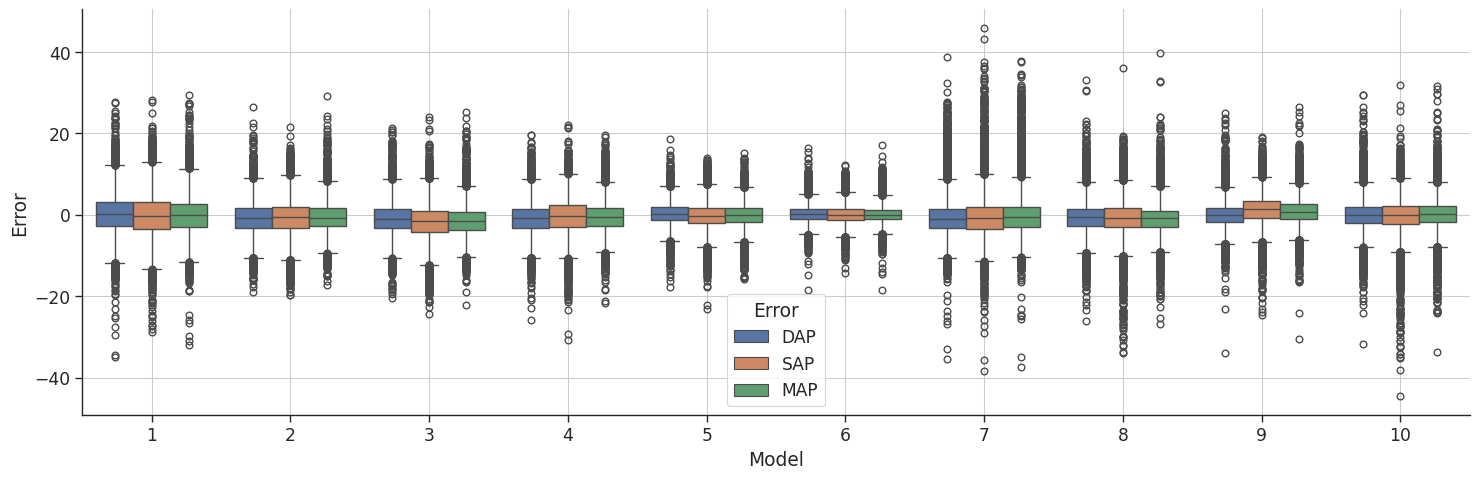

In [179]:
plt.figure(figsize=(15, 5))
sns.boxplot(
    x="Model",
    y="Error_val",
    data=combined_df,
    hue="Error",
    showfliers=True,
)  #  violinplot: , split=True
plt.ylabel("Error")
plt.grid(True)
plt.tight_layout()
# plt.xlim([-0.5, 25])
plt.show()
# plt.figure(figsize=(15,5))
# sns.boxplot(
#    x="Model",
#    y="Error_val",
#    data=combined_df,
#    hue="Error",
#    showfliers=False,

# )  #  violinplot: , split=True
# plt.ylabel("Error")
# plt.grid(True)
# plt.tight_layout()
##plt.xlim([-0.5, 25])
# plt.show()

In [164]:
# Wanna save the weights?
model.save_weights(f"models/model_aug/model_{m_idx}.weights.h5")

___